In [1]:
#data preprocessing
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import collections
from collections import defaultdict
#logistic regression model: train and evaluation and XGB 
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import seaborn as sns

from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, auc, accuracy_score
import sklearn.metrics as metrics
from sklearn.impute import SimpleImputer
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from matplotlib import pyplot as plt
import pyupset as pyu
import math

In [2]:
# the full files pathes are here
# time dependent
DATA_PATH_stages="../data/kdigo_stages_measured.csv" 
DATA_PATH_labs = "../data/labs-kdigo_stages_measured.csv" 
DATA_PATH_vitals = "../data/vitals-kdigo_stages_measured.csv" 
DATA_PATH_vents = "../data/vents-vasopressor-sedatives-kdigo_stages_measured.csv"
#no time dependent
DATA_PATH_detail="../data/icustay_detail-kdigo_stages_measured.csv" #age constraint
DATA_PATH_icd = "../data/diagnoses_icd_aki_measured.csv" #AL was "...measured 2.csv"

SEPARATOR=";"

In [3]:
# Set parameter as constant 
LOS = True # additional code to cut the records longer than 32 days

#which classifier to use, only run one classifier at one time 
ALL_STAGES = False
CLASS1 = True   #AnyAKI

    
SELECTED_FEATURE_SET = False
MAX_FEATURE_SET = True
DIAGNOSIS = False

MAX_DAYS = 35

NORMALIZATION = 'min-max'  # worsen results for XGB and RF
CAPPING = True

if CAPPING:
    CAPPING_THRESHOLD_UPPER = 0.99
    CAPPING_THRESHOLD_LOWER = 0.01

#Age constraints: adults
ADULTS_MIN_AGE = 18
ADULTS_MAX_AGE = -1

#Two options to deal with time series data
FIRST_TURN_POS = True #True #False # the first charttime that turn pos as bechmark for Target
LAST_CHARTTIME = False #the last charttime as bechmark for Target

# resampling or not
TIME_SAMPLING = True 
SAMPLING_INTERVAL = '6H'
RESAMPLE_LIMIT = 16 # 4 days*6h interval
MOST_COMMON = False #resampling with most common
# if MOST_COMMON is not applied,sampling with different strategies per kind of variable, 
# numeric variables use mean value, categorical variables use max value
IMPUTE_EACH_ID = False # imputation within each icustay_id
IMPUTE_COLUMN = False # imputation based on whole column
IMPUTE_METHOD = 'most_frequent' 
FILL_VALUE = 0 #fill missing value and ragged part of 3d array

# How much time the prediction should occur (hours)
HOURS_AHEAD = 48

# precentage of dataset to be used for testing model
TEST_SIZE = 0.3

NORM_TYPE = 'min_max'

# set constant for function build_basic_LR
C = 0.1
PENALTY = "l1"
SOLVER = 'saga' 
MAX_ITERATION = 1000 
CLASS_WEIGHT = "balanced"
RANDOM = 42

#set changable info corresponding to each classifier as variables

#min_set =  ["icustay_id", "charttime", "creat", "uo_rt_6hr", "uo_rt_12hr", "uo_rt_24hr", "aki_stage"]


#selected_set = 


max_set = ["icustay_id", "charttime", 'hadm_id', "creat", "aki_stage_creat", "uo_rt_6hr","uo_rt_12hr", "uo_rt_24hr", 
                  "aki_stage_uo", "aki_stage", "aniongap_min","albumin_min", "bicarbonate_min", "bilirubin_min", 
                  "chloride_min", "glucose_min", "hematocrit_min", "hemoglobin_min", "potassium_min", "ptt_min",            
                  "sodium_min" , "bun_min" , "wbc_min" , "heartrate_mean" , "sysbp_mean", "diasbp_mean" , "resprate_mean",
                  "vent", "vasopressor", "sedative"]

# naming model and plot
classifier_name = "None vs. Any AKI"    ###change every time #Moderate vs. Severe #None vs. Any #Others vs. Severe
plot_name = "adult_AnyAKI_LR"    ###change every time

In [4]:
# Some functions used later

if CAPPING:
    def cap_data(df):
        cap_mask = df.columns.difference(['icustay_id', 'charttime', 'aki_stage'])
        df[cap_mask] = df[cap_mask].clip(df[cap_mask].quantile(CAPPING_THRESHOLD_LOWER),
                                         df[cap_mask].quantile(CAPPING_THRESHOLD_UPPER),
                                         axis=1)

        return df

# impute missing value in resampleing data with most common based on each id
def fast_mode(df, key_cols, value_col):
    """ 
    Calculate a column mode, by group, ignoring null values. 

    key_cols : list of str
        Columns to groupby for calculation of mode.
    value_col : str
        Column for which to calculate the mode. 

    Return
    ------ 
    pandas.DataFrame
        One row for the mode of value_col per key_cols group. If ties, 
        returns the one which is sorted first. 
    """
    return (df.groupby(key_cols + [value_col]).size() 
              .to_frame('counts').reset_index() 
              .sort_values('counts', ascending=False) 
              .drop_duplicates(subset=key_cols)).drop('counts',axis=1)


def normalise_data(df, norm_mask):
    print("Normalizing in [0,1] with {} normalization".format(NORMALIZATION))
    
    df[norm_mask] = (df[norm_mask] - df[norm_mask].min()) / (df[norm_mask].max() - df[norm_mask].min())
    
    return df


#get max shape of 3d array
def get_dimensions(array, level=0):   
    yield level, len(array)
    try:
        for row in array:
            yield from get_dimensions(row, level + 1)
    except TypeError: #not an iterable
        pass

def get_max_shape(array):
    dimensions = defaultdict(int)
    for level, length in get_dimensions(array):
        dimensions[level] = max(dimensions[level], length)
    return [value for _, value in sorted(dimensions.items())]

#pad the ragged 3d array to rectangular shape based on max size
def iterate_nested_array(array, index=()):
    try:
        for idx, row in enumerate(array):
            yield from iterate_nested_array(row, (*index, idx)) 
    except TypeError: # final level            
        yield (*index, slice(len(array))), array # think of the types

def pad(array, fill_value):
    dimensions = get_max_shape(array)
    result = np.full(dimensions, fill_value, dtype = np.float64)  
    for index, value in iterate_nested_array(array):
        result[index] = value 
    return result

def bin_total(y_true, y_prob, n_bins):
    bins = np.linspace(0., 1. + 1e-8, n_bins + 1)

    # In sklearn.calibration.calibration_curve,
    # the last value in the array is always 0.
    binids = np.digitize(y_prob, bins) - 1

    return np.bincount(binids, minlength=len(bins))

def missing_bin(bin_array):
    midpoint = " "    
    if bin_array[0]==0:
        midpoint = "5%, "
    if bin_array[1]==0:
        midpoint = midpoint + "15%, "
    if bin_array[2]==0:
        midpoint = midpoint + "25%, "
    if bin_array[3]==0:
        midpoint = midpoint + "35%, " 
    if bin_array[4]==0:
        midpoint = midpoint + "45%, "
    if bin_array[5]==0:
        midpoint = midpoint + "55%, "
    if bin_array[6]==0:
        midpoint = midpoint + "65%, "
    if bin_array[7]==0:
        midpoint = midpoint + "75%, "
    if bin_array[8]==0:
        midpoint = midpoint + "85%, "
    if bin_array[9]==0:
        midpoint = midpoint + "95%, "
    return "The missing bins have midpoint values of "+ str(midpoint)


# Download data fron CSV tables

In [5]:
print("read csv files")
#reading csv files
X = pd.read_csv(DATA_PATH_stages, sep= SEPARATOR)
X.drop(["aki_stage_creat", "aki_stage_uo"], axis = 1, inplace = True)
#remove totally empty rows 
X = X.dropna(how = 'all', subset = ['creat','uo_rt_6hr','uo_rt_12hr','uo_rt_24hr','aki_stage'])
print("convert charttime to timestamp")
X['charttime'] = pd.to_datetime(X['charttime'])
# AL it substitutes missing values with zero!
#merge rows if they have exact timestamp within same icustay_id
#X = X.groupby(['icustay_id', 'charttime']).sum().reset_index(['icustay_id', 'charttime'])

dataset_detail = pd.read_csv(DATA_PATH_detail, sep= SEPARATOR)  #age constraint
dataset_detail.drop(['dod', 'admittime','dischtime', 'los_hospital','ethnicity','hospital_expire_flag', 'hospstay_seq',
       'first_hosp_stay', 'intime', 'outtime', 'los_icu', 'icustay_seq','first_icu_stay'], axis = 1, inplace = True)


read csv files
convert charttime to timestamp


In [108]:
print("uo_rt_6hr %.2f" % (X.isnull().sum()[3]/X.shape[0]*100))

uo_rt_6hr 12.31


In [109]:
# DATASET X % of missing per column
#print("creat %.2f" % (X.isnull().sum()[2]/X.shape[0]*100))
print("uo_rt_6hr %.2f" % (X.isnull().sum()[3]/X.shape[0]*100))
print("percentage fo rows having both measures on a timestamp %.2f" % (X.dropna().shape[0]/X.shape[0]*100))
X.dropna().shape[0]
X = cap_data(X)
X.isnull().sum()



uo_rt_6hr 12.31
percentage fo rows having both measures on a timestamp 0.35


icustay_id          0
charttime           0
creat         3290149
uo_rt_6hr      463867
uo_rt_12hr     463867
uo_rt_24hr     463867
aki_stage           0
dtype: int64

In [110]:
def describe_series(series):
    series = series.dropna()
    d = series.describe()
    result = pd.DataFrame({'feature':d})
    return result
    

In [111]:
result = describe_series(X['uo_rt_24hr'])
result.apply(lambda x: '%.5f' % x, axis=1)

count    3303496.00000
mean           1.38108
std            1.11269
min            0.03550
25%            0.66110
50%            1.09140
75%            1.73000
max            6.38300
dtype: object

In [112]:
print('subject ids')
print(dataset_detail['subject_id'].nunique())
dataset_detail['admission_type'].value_counts()
dataset_detail.isnull().sum()

subject ids
42078


subject_id           0
hadm_id              0
icustay_id           0
gender               0
age                  0
ethnicity_grouped    0
admission_type       0
dtype: int64

In [78]:
dataset_detail['ethnicity_grouped'].value_counts()

white       40265
unknown      5892
black        5446
hispanic     1973
other        1602
asian        1438
native         45
Name: ethnicity_grouped, dtype: int64

In [79]:
#unknown
dataset_detail['ethnicity_grouped'].value_counts()[1]/dataset_detail.shape[0]*100

10.39868692751628

# vitals and vents

In [14]:
#min max mean - either all missing or all present (checked)
'''
dataset_vitals = pd.read_csv(DATA_PATH_vitals, sep= SEPARATOR)
dataset_vitals.drop(['meanbp_min','meanbp_max', 'meanbp_mean','tempc_min', 'tempc_max', 'tempc_mean'], axis = 1, inplace = True)
dataset_vitals.shape 

row = 715520
a = dataset_vitals.iloc[row,col1]
b = dataset_vitals.iloc[row,col2]
c = dataset_vitals.iloc[row,col3]
print(a, b, c)

row = 3025107
a = dataset_vitals.iloc[row,col1]
b = dataset_vitals.iloc[row,col2]
c = dataset_vitals.iloc[row,col3]
print(a, b, c)

row = 3888829
a = dataset_vitals.iloc[row,col1]
b = dataset_vitals.iloc[row,col2]
c = dataset_vitals.iloc[row,col3]
print(a, b, c)

row = 4181716
a = dataset_vitals.iloc[row,col1]
b = dataset_vitals.iloc[row,col2]
c = dataset_vitals.iloc[row,col3]
print(a, b, c)

row = 4181720
a = dataset_vitals.iloc[row,col1]
b = dataset_vitals.iloc[row,col2]
c = dataset_vitals.iloc[row,col3]
print(a, b, c)
'''

NameError: name 'col1' is not defined

In [ ]:
#min max mean - either all missing or all present (checked)
'''
#heartrate
row = 0
col1 = 19
col2 = 20
col3 = 21
different = []

min_v = []
mean_v = []
max_v = []

while row < dataset_vitals.shape[0]:  
    a = dataset_vitals.iloc[row,col1]
    b = dataset_vitals.iloc[row,col2]
    c = dataset_vitals.iloc[row,col3]
    if math.isnan(a) and math.isnan(b) and math.isnan(c):
        pass
    elif a !=b or b !=c or c !=a:
        #print(row)
        different.append(row)
        min_v.append(a)
        mean_v.append(b)
        max_v.append(c)
    if row == 2270220:
        print('25%')
    if row == 4540440:
        print('50%')
    if row == 6810660:
        print('75%')
    row +=1

check = pd.DataFrame()
check['min']  = min_v
check['mean']  = mean_v
check['max'] = max_v

check.isnull().sum()
'''

In [6]:
if SELECTED_FEATURE_SET or MAX_FEATURE_SET:
    #4,5,6
    dataset_vitals = pd.read_csv(DATA_PATH_vitals, sep= SEPARATOR)  #'meanbp_mean', 'tempc_mean',
    dataset_vents = pd.read_csv(DATA_PATH_vents , sep= SEPARATOR)
    #dataset_icd = pd.read_csv(DATA_PATH_icd, sep= SEPARATOR)

    dataset_vitals.drop(["heartrate_min", "heartrate_max","sysbp_min", "sysbp_max","diasbp_min", "diasbp_max",
                        'meanbp_min','meanbp_max', 'meanbp_mean','tempc_min', 'tempc_max', 'tempc_mean',
                        "resprate_min", "resprate_max", "spo2_min", "spo2_max", "glucose_min", "glucose_max"], axis = 1, inplace = True)
          
    print("convert charttime to timestamp")
    dataset_vitals['charttime'] = pd.to_datetime(dataset_vitals['charttime'])
    dataset_vents['charttime'] = pd.to_datetime(dataset_vents['charttime'])
    
    dataset_vitals = dataset_vitals.sort_values(by=['icustay_id', 'charttime'])
    dataset_vents = dataset_vents.sort_values(by=['icustay_id', 'charttime'])
    
    # AL drop those where all columns are nan
    dataset_vitals = dataset_vitals.dropna(subset=dataset_vitals.columns[4:], how='all')   
    dataset_vitals = cap_data(dataset_vitals)
     

convert charttime to timestamp


In [114]:
# VITALS % of missing per column
print("heartrate %.2f" % (dataset_vitals.isnull().sum()[4]/dataset_vitals.shape[0]*100) )
print("sysbp_mean %.2f" % (dataset_vitals.isnull().sum()[5]/dataset_vitals.shape[0]*100))
print("diasbp_mean %.2f" % (dataset_vitals.isnull().sum()[6]/dataset_vitals.shape[0]*100))
print("resprate_mean %.2f" % (dataset_vitals.isnull().sum()[7]/dataset_vitals.shape[0]*100))
print("spo2_mean %.2f" % (dataset_vitals.isnull().sum()[8]/dataset_vitals.shape[0]*100))
print("glucose_mean %.2f" % (dataset_vitals.isnull().sum()[9]/dataset_vitals.shape[0]*100))


print("percentage fo rows having all measures on a timestamp %.2f" % (dataset_vitals.dropna().shape[0]/dataset_vitals.shape[0]*100))
dataset_vitals.dropna().shape[0]
#print("tempc_mean %.2f" % (dataset_vitals.isnull().sum()[8]/dataset_vitals.shape[0]*100)) 80.85% missing
dataset_vitals.isnull().sum()

heartrate 12.95
sysbp_mean 36.02
diasbp_mean 36.04
resprate_mean 30.55
spo2_mean 32.68
glucose_mean 86.03
percentage fo rows having all measures on a timestamp 7.28


subject_id              0
hadm_id                 0
icustay_id              0
charttime               0
heartrate_mean    1169644
sysbp_mean        3252955
diasbp_mean       3254742
resprate_mean     2758605
spo2_mean         2950969
glucose_mean      7768785
dtype: int64

In [82]:
a = describe_series(dataset_vitals['spo2_mean'])
a.apply(lambda x: '%.5f' % x, axis=1)


count    6079499.00000
mean          97.17875
std            2.73069
min           87.00000
25%           96.00000
50%           98.00000
75%           99.00000
max          100.00000
dtype: object

# labs

In [7]:
#3
dataset_labs = pd.read_csv(DATA_PATH_labs, sep= SEPARATOR) # 'bands lactate platelet ptt inr pt
dataset_labs.drop(['albumin_min', 'albumin_max','bilirubin_min', 'bilirubin_max','bands_min', 'bands_max',
                   'lactate_min', 'lactate_max','platelet_min', 'platelet_max','ptt_min', 'ptt_max', 
                   'inr_min', 'inr_max', 'pt_min', 'pt_max'], axis = 1, inplace = True)
dataset_labs = dataset_labs.dropna(subset=['charttime'])
dataset_labs = dataset_labs.dropna(subset=dataset_labs.columns[4:], how='all')
dataset_labs['charttime'] = pd.to_datetime(dataset_labs['charttime'])
dataset_labs = dataset_labs.sort_values(by=['icustay_id', 'charttime'])
dataset_labs = cap_data(dataset_labs)

In [8]:
# Labs file: instead of min and max their avg
counter = 0
col1 = 4
col2 = 5
null_l = [] # no null values in those that are different
changed = 0 # 4316 records changed to avg

while counter < 11:
    row = 0
# find where min and max are different and save their row indices 
    while row < len(dataset_labs):
        a = dataset_labs.iloc[row,col1]
        b = dataset_labs.iloc[row,col2]
        if a==b or (np.isnan(a) and np.isnan(b)):
            pass
        elif a!=b:
            changed +=1
            avg = (a+b)/2
            dataset_labs.iloc[row,col1] = avg
            if (np.isnan(a) and ~np.isnan(b)) or (np.isnan(b) and ~np.isnan(a)):
                null_l.append(row)
        else:
            print(a)
            print(b)
        row +=1       
    # delete the redundant column max, update counters
    dataset_labs.drop(dataset_labs.columns[col2], axis=1, inplace = True)
    counter = counter+1
    col1 = col1+1
    col2 = col2+1

dataset_labs.columns = ['subject_id','hadm_id', 'icustay_id', 'charttime', 'aniongap_avg', 'bicarbonate_avg', 
                        'creatinine_avg', 'chloride_avg', 'glucose_avg', 'hematocrit_avg','hemoglobin_avg',
                        'potassium_avg', 'sodium_avg', 'bun_avg', 'wbc_avg']
if len(null_l)>0:
    print("null values encountered")

In [85]:
# LABS1 % of missing per column
print("aniongap_avg %.2f" % (dataset_labs.isnull().sum()[4]/dataset_labs.shape[0]*100) )
print("bicarbonate_avg %.2f" % (dataset_labs.isnull().sum()[5]/dataset_labs.shape[0]*100))
print("creatinine_avg %.2f" % (dataset_labs.isnull().sum()[6]/dataset_labs.shape[0]*100))
print("chloride_avg %.2f" % (dataset_labs.isnull().sum()[7]/dataset_labs.shape[0]*100))
print("glucose_avg %.2f" % (dataset_labs.isnull().sum()[8]/dataset_labs.shape[0]*100) )
print("hematocrit_avg %.2f" % (dataset_labs.isnull().sum()[9]/dataset_labs.shape[0]*100))
print("hemoglobin_avg %.2f" % (dataset_labs.isnull().sum()[10]/dataset_labs.shape[0]*100))
print("potassium_avg %.2f" % (dataset_labs.isnull().sum()[11]/dataset_labs.shape[0]*100))
print("sodium_avg %.2f" % (dataset_labs.isnull().sum()[12]/dataset_labs.shape[0]*100))
print("bun_avg %.2f" % (dataset_labs.isnull().sum()[13]/dataset_labs.shape[0]*100))
print("wbc_avg %.2f" % (dataset_labs.isnull().sum()[14]/dataset_labs.shape[0]*100))
#print("lactate %.2f" % (dataset_labs.isnull().sum()[17]/dataset_labs.shape[0]*100))
#print("platelet %.2f" % (dataset_labs.isnull().sum()[19]/dataset_labs.shape[0]*100))


print("percentage fo rows having all measures on a timestamp %.2f" % (dataset_labs.dropna().shape[0]/dataset_labs.shape[0]*100))
dataset_labs.dropna().shape[0]

aniongap_avg 43.09
bicarbonate_avg 42.19
creatinine_avg 42.00
chloride_avg 36.89
glucose_avg 26.76
hematocrit_avg 27.96
hemoglobin_avg 38.82
potassium_avg 20.86
sodium_avg 33.93
bun_avg 42.20
wbc_avg 46.24
percentage fo rows having all measures on a timestamp 46.04


589184

In [22]:
dataset_labs.isnull().sum()

subject_id              0
hadm_id                 0
icustay_id              0
charttime               0
aniongap_avg       551516
bicarbonate_avg    539995
creatinine_avg     537526
chloride_avg       472049
glucose_avg        342419
hematocrit_avg     357857
hemoglobin_avg     496776
potassium_avg      266911
sodium_avg         434181
bun_avg            540020
wbc_avg            591785
dtype: int64

In [23]:
dataset_labs.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'charttime', 'aniongap_avg',
       'bicarbonate_avg', 'creatinine_avg', 'chloride_avg', 'glucose_avg',
       'hematocrit_avg', 'hemoglobin_avg', 'potassium_avg', 'sodium_avg',
       'bun_avg', 'wbc_avg'],
      dtype='object')

In [24]:
a = describe_series(dataset_labs['sodium_avg'])
print(a.apply(lambda x: '%.5f' % x, axis=1))


count    845592.00000
mean        138.39087
std           4.89839
min         125.00000
25%         135.00000
50%         138.00000
75%         141.00000
max         151.00000
dtype: object


In [9]:
print("Merge creatinine and glucose.")
# merge creatinine from labs and set with labels
creat_l = dataset_labs[['icustay_id','charttime','creatinine_avg']].copy()
creat_l = creat_l.dropna(subset=['creatinine_avg'])
creat = X[['icustay_id','charttime', 'creat']].copy()
creat = creat.dropna(subset=['creat'])
creat_l = creat_l.rename(columns={"creatinine_avg": "creat"})
creat = creat.append(creat_l, ignore_index=True)
creat.drop_duplicates(inplace = True)
#delete old columns
dataset_labs.drop(["creatinine_avg"], axis = 1, inplace = True)
dataset_labs = dataset_labs.dropna(subset=dataset_labs.columns[4:], how='all')
X.drop(["creat"], axis = 1, inplace = True)
#merge new column
X = pd.merge(X, creat, on = ["icustay_id", "charttime"], sort = True, how= "outer", copy = False)
if SELECTED_FEATURE_SET or MAX_FEATURE_SET:
    # merge glucose from vitals and labs
    glucose_v = dataset_vitals[['subject_id','hadm_id','icustay_id','charttime', 'glucose_mean']].copy()
    glucose_v = glucose_v.dropna(subset=['glucose_mean'])
    glucose = dataset_labs[['subject_id','hadm_id','icustay_id','charttime', 'glucose_avg']].copy()
    glucose = glucose.dropna(subset=['glucose_avg'])
    glucose_v = glucose_v.rename(columns={"glucose_mean": "glucose_avg"})
    glucose = glucose.append(glucose_v, ignore_index=True)
    glucose.drop_duplicates(inplace = True)
    #delete old columns
    dataset_labs.drop(["glucose_avg"], axis = 1, inplace = True)
    dataset_vitals.drop(["glucose_mean"], axis = 1, inplace = True)
    dataset_vitals = dataset_vitals.dropna(subset=dataset_vitals.columns[4:], how='all')
    #merge new column
    dataset_labs = pd.merge(dataset_labs, glucose, on = ['subject_id','hadm_id','icustay_id','charttime',], sort = True, how= "outer", copy = False)
dataset_labs = dataset_labs.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
X = X.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)   

Merge creatinine and glucose.


In [26]:
print("creat %.2f" % (X.isnull().sum()[6]/X.shape[0]*100))

creat 81.24


In [27]:
a = describe_series(X['creat'])
print(a.apply(lambda x: '%.5f' % x, axis=1))

count    758795.00000
mean          1.57177
std           1.54648
min           0.30000
25%           0.70000
50%           1.00000
75%           1.70000
max           8.50000
dtype: object


In [28]:
print("glucose_avg %.2f" % (dataset_labs.isnull().sum()[13]/dataset_labs.shape[0]*100))

glucose_avg 15.42


In [29]:
a = describe_series(dataset_labs['glucose_avg'])
print(a.apply(lambda x: '%.5f' % x, axis=1))

count    1859581.00000
mean         137.49621
std           51.75584
min           58.00000
25%          104.00000
50%          126.00000
75%          157.00000
max          350.00000
dtype: object


In [30]:
dataset_labs.isnull().sum()

subject_id               0
hadm_id                  0
icustay_id               0
charttime                0
aniongap_avg       1461145
bicarbonate_avg    1449554
chloride_avg       1381146
hematocrit_avg     1268637
hemoglobin_avg     1408025
potassium_avg      1174712
sodium_avg         1342985
bun_avg            1449678
wbc_avg            1503487
glucose_avg         339045
dtype: int64

In [31]:
X.isnull().sum()

icustay_id          0
charttime           0
uo_rt_6hr      740408
uo_rt_12hr     740408
uo_rt_24hr     740408
aki_stage      271143
creat         3285185
dtype: int64

In [118]:
# DATASET X % of missing per column
print("creat %.2f" % (X.isnull().sum()[6]/X.shape[0]*100))
#print("uo_rt_6hr %.2f" % (X.isnull().sum()[2]/X.shape[0]*100))
print("percentage fo rows having both measures on a timestamp %.2f" % (X.dropna().shape[0]/X.shape[0]*100))
X.dropna().shape[0]

creat 81.24
percentage fo rows having both measures on a timestamp 0.45


18387

In [10]:
print("Merging labs, vitals and vents files")
#merge files with time-dependent data, based on icustay_id and charttime
if SELECTED_FEATURE_SET or MAX_FEATURE_SET:
    X = pd.merge(X, dataset_labs, on = ["icustay_id", "charttime"], how= "outer", copy = False)
    X = pd.merge(X, dataset_vitals, on = ["icustay_id", "charttime","subject_id", "hadm_id"], how= "outer", copy = False)
    X = pd.merge(X, dataset_vents, on = ["icustay_id", "charttime"], how= "outer", copy = False) 
    X.drop(["subject_id"], axis = 1, inplace = True) 


Merging labs, vitals and vents files


In [34]:
X['icustay_id'].nunique()

56661

In [35]:
dataset_detail['subject_id'].nunique()

42078

In [11]:
print("start preprocessing time dependent data") # AL removed a line where rows with missing labels are deleted (we will ffil)
print("Removing patients under the min age")
dataset_detail = dataset_detail.loc[dataset_detail['age'] >= ADULTS_MIN_AGE]
adults_icustay_id_list = dataset_detail['icustay_id'].unique()
X = X[X.icustay_id.isin(adults_icustay_id_list)].sort_values(by=['icustay_id'], ignore_index = True)
X = X.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
adults_icustay_id_list = np.sort(adults_icustay_id_list)

start preprocessing time dependent data
Removing patients under the min age


In [12]:
print("drop icustay_id with time span less than 48hrs")
def more_than_HOURS_ahead(adults_icustay_id_list, X):
    drop_list = []
    los_list = [] # calculating LOS ICU based on charttime
    long_stays_id = [] # LOS longer than MAX DAYS days
    last_charttime_list = []
    seq_length = X.groupby(['icustay_id'],as_index=False).size()
    id_count = 0
    first_row_index = 0

    while id_count < len(adults_icustay_id_list):
        icustay_id = adults_icustay_id_list[id_count]
        last_row_index = first_row_index + seq_length.iloc[id_count,1]-1
        first_time = X.iat[first_row_index, X.columns.get_loc('charttime')]
        last_time = X.iat[last_row_index, X.columns.get_loc('charttime')]
        los = round(float((last_time - first_time).total_seconds()/60/60/24),4) # in days
        if los < HOURS_AHEAD/24:
            drop_list.append(icustay_id)
        else:
            los_list.append(los)
            if los > MAX_DAYS:
                long_stays_id.append(icustay_id)
                last_charttime_list.append(last_time)
        # udpate for the next icustay_id
        first_row_index = last_row_index+1
        id_count +=1
    if len(long_stays_id) != len(last_charttime_list):
        print('ERROR')
    print("%d long stays" % len(long_stays_id))
    # drop all the rows with the saved icustay_id
    print("there are %d id-s shorter than 48 hours" % len(drop_list))
    X = X[~X.icustay_id.isin(drop_list)]
    id_list = X['icustay_id'].unique()
    X = X.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
    
    return id_list, X, long_stays_id,last_charttime_list, los_list

id_list, X, long_stays_id,last_charttime_list, los_list  = more_than_HOURS_ahead(adults_icustay_id_list, X)


long = pd.DataFrame()
long['icustay_id']  = long_stays_id
long['last_time']  = last_charttime_list
dataset_detail = dataset_detail[dataset_detail.icustay_id.isin(id_list)].sort_values(by=['icustay_id'], ignore_index = True)


drop icustay_id with time span less than 48hrs
2302 long stays
there are 5214 id-s shorter than 48 hours


In [123]:
dataset_detail['ICU_LOS_days'] = los_list
print(len(los_list))

47752


In [134]:
l1 = [los for los in dataset_detail['ICU_LOS_days'] if los >=30] #3200 records 6.7%
l2 = [los for los in dataset_detail['ICU_LOS_days'] if los >=35] #2302 records 4.8%
l3 = [los for los in dataset_detail['ICU_LOS_days'] if los >=40] #1690 records 3.5%
l4 = [los for los in dataset_detail['ICU_LOS_days'] if los >=45] #1276 records  2.7%
l5 = [los for los in dataset_detail['ICU_LOS_days'] if los >=50] #1020 records 2.1%
l6 = [los for los in dataset_detail['ICU_LOS_days'] if los >=55] #802 records 1.7%

In [135]:
len(l6)

802

In [93]:
# deleting rows that are not within MAX_DAYS (35) period
i = 0 # long df index
drop_long_time = []
    
while i < len(long_stays_id):
    j = 0
    all_rows = X.index[X['icustay_id'] == long.loc[i,'icustay_id']].tolist()
    while j < len(all_rows):
        time = X.iat[all_rows[j], X.columns.get_loc('charttime')]
        # if keep last MAX_DAYS 
        if (long.loc[i,'last_time'] - time).total_seconds() > MAX_DAYS*24*60*60:
            drop_long_time.append(all_rows[j])
            j +=1
        else:
            break
    i +=1       
X.drop(X.index[drop_long_time], inplace=True) 

# checking for 48h min length again
id_list, X, long_stays_id,last_charttime_list, los_list  = more_than_HOURS_ahead(id_list, X)
dataset_detail = dataset_detail[dataset_detail.icustay_id.isin(id_list)].sort_values(by=['icustay_id'], ignore_index = True)


0 long stays
there are 1 id-s shorter than 48 hours


In [20]:
id_list

array([200001, 200003, 200006, ..., 299995, 299998, 299999])

In [ ]:
#subjects = list(dataset_detail['subject_id'].unique())
#dataset_icd= dataset_icd[dataset_icd.subject_id.isin(subjects)].sort_values(by=['subject_id'], ignore_index = True)
#dataset_icd['icd9_code'].value_counts().sort_values(ascending = False)

In [35]:
seq_length = X.groupby(['icustay_id'],as_index=False).size()
id_count = 0
first_row_index = 0
dead_id = []
lastt = []
deatht = []

while id_count < dataset_detail.shape[0]:
    #print(id_count)
    icustay_id = id_list[id_count]
    last_row_index = first_row_index + seq_length.iloc[id_count,1]-1
    last_time = X.iat[last_row_index, X.columns.get_loc('charttime')]
    death_time = dataset_detail.iat[id_count,dataset_detail.columns.get_loc('dod')]
    if death_time==pd._libs.tslibs.nattype.NaTType:
        pass
    elif last_time>death_time:
        dead_id.append(icustay_id)
        lastt.append(last_time)
        deatht.append(death_time)
    id_count +=1
    first_row_index = last_row_index+1
    
        

In [31]:
#dataset_detail = pd.read_csv(DATA_PATH_detail, sep= SEPARATOR)
#dataset_detail = dataset_detail[dataset_detail.icustay_id.isin(id_list)].sort_values(by=['icustay_id'], ignore_index = True)
dataset_detail['dod'] = pd.to_datetime(dataset_detail['dod'])
type(dataset_detail.iloc[3,4])


True

In [36]:
dod = pd.DataFrame()
dod['icustay_id']  = dead_id
dod['last'] = lastt
dod['dod'] = deatht
dod

,icustay_id,last,dod
0,200019,2178-07-11 05:00:00,2178-07-11
1,200024,2127-03-03 20:00:00,2127-03-03
2,200033,2198-08-21 12:00:00,2198-08-21
3,200095,2113-10-31 00:15:00,2113-10-31
4,200102,2193-06-27 16:00:00,2193-06-27
...,...,...,...
3889,299813,2125-12-03 17:37:00,2125-12-03
3890,299852,2124-11-19 20:00:00,2124-11-19
3891,299867,2186-08-02 14:31:00,2186-08-02
3892,299889,2172-06-09 04:00:00,2172-06-09


# data description

[Text(0, 0, 'No AKI'),
 Text(1, 0, 'Only stage 1'),
 Text(2, 0, 'Only stage 2'),
 Text(3, 0, '1 and 2 stages'),
 Text(4, 0, 'Only stage 3'),
 Text(5, 0, '1 and 3 stages'),
 Text(6, 0, '2 and 3 stages'),
 Text(7, 0, 'All AKI stages')]

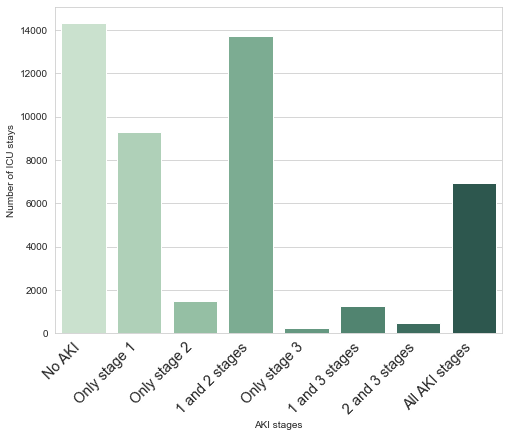

In [37]:
############################## AKI ############################################
no_aki = []
only_aki1 = []
only_aki2=  []
only_aki3 = []
aki1_aki2 = []
aki2_aki3 = []
aki1_aki3 = []
aki123 = []
    
for ID in id_list:
    a = X.loc[X['icustay_id']==ID].aki_stage
    if 1 in a.values and 2 in a.values and 3 in a.values:
        aki123.append(ID)
    if 1 in a.values and 2 in a.values and 3 not in a.values:
        aki1_aki2.append(ID)
    if 1 in a.values and 2 not in a.values and 3 in a.values:
        aki1_aki3.append(ID)
    if 1 not in a.values and 2 in a.values and 3 in a.values:
        aki2_aki3.append(ID)
    if 1 in a.values and 2 not in a.values and 3 not in a.values:
        only_aki1.append(ID)
    if 1 not in a.values and 2 in a.values and 3 not in a.values:
        only_aki2.append(ID)
    if 1 not in a.values and 2 not in a.values and 3 in a.values:
        only_aki3.append(ID)
    if 1 not in a.values and 2 not in a.values and 3 not in a.values:
        no_aki.append(ID)
    
names =  ['No AKI', 'Only stage 1', 'Only stage 2', '1 and 2 stages','Only stage 3','1 and 3 stages', '2 and 3 stages','All AKI stages']      
values =  [len(no_aki), len(only_aki1), len(only_aki2), len(aki1_aki2),len(only_aki3), len(aki1_aki3), len(aki2_aki3), len(aki123)]      
aki = pd.DataFrame({'AKI stages':names, 'Number of ICU stays': values})
sns.set_style('whitegrid')
plt.figure(figsize=(8,6))
chart = sns.barplot(x='AKI stages', y='Number of ICU stays', hue=None, data=aki, order=None, hue_order=None, units=None, seed=None, orient=None, color=None, palette='ch:2.5,-.2,dark=.3', saturation=0.75, errcolor='.26', errwidth=None, capsize=None, dodge=True, ax=None)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45,horizontalalignment='right', fontsize='x-large')

In [39]:
len(no_aki)

14338

In [40]:
# 3580 out of those who died had AKI 
counter = 3894
for i in dead_id:
    if i in no_aki:
        counter -=1
print(counter)

3580


In [37]:
data_dict = {
  "No AKI": len(no_aki),
  "Only stage 1": len(only_aki1),
  "Only stage 2": len(only_aki2),
  "1 and 2 stages": len(aki1_aki2),
  "Only stage 3": len(only_aki3),
  "1 and 3 stages": len(aki1_aki3),
  "2 and 3 stages": len(aki2_aki3),
  "All AKI stages":len(aki123)    
}

In [56]:
from upsetplot import generate_counts
example = generate_counts()
example

cat0   cat1   cat2 
False  False  False      56
              True      283
       True   False    1279
              True     5882
True   False  False      24
              True       90
       True   False     429
              True     1957
Name: value, dtype: int64

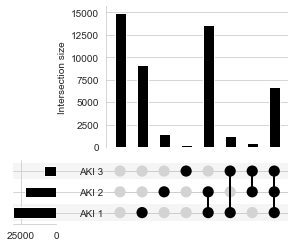

In [75]:
import upsetplot
from upsetplot import from_memberships

  
# Creating the row axis labels 



example = from_memberships(
     [[],
      ['AKI 1'],
      ['AKI 2'],
      ['AKI 1', 'AKI 2'],
      ['AKI 3'],
      ['AKI 1', 'AKI 3'],
      ['AKI 2', 'AKI 3'],
      ['AKI 1', 'AKI 2', 'AKI 3'],
      ],
      data=[len(no_aki), len(only_aki1),len(only_aki2),len(aki1_aki2),len(only_aki3),len(aki1_aki3),len(aki2_aki3),
           len(aki123)]
 )

#example.index = ['No AKI', 'Only stage 1', 'Only stage 2', '1 and 2 stages', 'Only stage 3', '1 and 3 stages', '2 and 3 stages','All AKI stages' ]  

from upsetplot import plot
plot(example) 
plt.savefig('Upset.png', dpi = 300) 

#plt.show()  

#example


In [40]:
if ALL_STAGES:
    pass
elif CLASS1:
    X.loc[X['aki_stage'] > 1, 'aki_stage'] = 1
elif CLASS2:
    X.loc[X['aki_stage'] < 2, 'aki_stage'] = 0
    X.loc[X['aki_stage'] > 1, 'aki_stage'] = 1
elif CLASS3:
    X.loc[X['aki_stage'] < 3, 'aki_stage'] = 0
    X.loc[X['aki_stage'] > 2, 'aki_stage'] = 1

In [41]:
print(dataset_detail['icustay_id'].nunique())
print(X['icustay_id'].nunique())
print(dataset_detail['subject_id'].nunique())


47751
47751
34516


In [42]:
# DEVISION BY ICUSTAY ID
positive_list = []
negative_list = []
  
for ID in id_list:
    a = X.loc[X['icustay_id']==ID].aki_stage
    if 1 in a.values:
        positive_list.append(ID)
    else:
        negative_list.append(ID)

print("lists_done")
############################ 1) DETAIL FILE ###################################

subj_pos = []
subj_neg = []
patients_id = dataset_detail['subject_id'].unique()

for ID in patients_id:
    a = dataset_detail.loc[dataset_detail['subject_id']==ID].icustay_id
    b=0
    for stayid in a:
        if stayid in positive_list:
            b=b+1
    if b>0:
        subj_pos.append(ID)
    else:
        subj_neg.append(ID) 
# DEVISION BY PATIENT
dataset_pos = dataset_detail[dataset_detail.subject_id.isin(subj_pos)].sort_values(by=['icustay_id'])
dataset_neg = dataset_detail[dataset_detail.subject_id.isin(subj_neg)].sort_values(by=['icustay_id'])
    
print("patients with AKI")
print(len(subj_pos))
print("patients without AKI")
print(len(subj_neg))

lists_done
patients with AKI
24935
patients without AKI
9581


In [43]:
#1 All
#df = dataset_detail.copy(deep = True)
#2 without AKI (option1)
df = dataset_neg.copy(deep = True)   
#3 WITH AKI (Option2)
#df = dataset_pos.copy(deep = True)

### patients

print("18+ " +str(df['subject_id'].nunique()) +" unique patient id-s.")   
subject = []
ethnicity = []
gender = []
row = -1
while row < df.shape[0]-1:
    row = row+1
    if df.iat[row, df.columns.get_loc('subject_id')] in subject:
        continue
    else:
        subject.append(df.iat[row, df.columns.get_loc('subject_id')])
        gender.append(df.iat[row, df.columns.get_loc('gender')])
        ethnicity.append(df.iat[row, df.columns.get_loc('ethnicity_grouped')])
        '''if df.iat[row, df.columns.get_loc('age')] >=89: 
            age.append(90)
        else:
            age.append(df.iat[row, df.columns.get_loc('age')])'''
            
patients = pd.DataFrame({'subject_id':subject, 'ethnicity': ethnicity, 'gender': gender})
                            
gender = patients['gender'].value_counts()
print("There are "+ str(gender[0])+ " male patients and " + str(gender[1])+ " female patients.\n ")      
print(patients['ethnicity'].value_counts())

18+ 9581 unique patient id-s.
There are 5382 male patients and 4199 female patients.
 
white       6712
unknown     1048
black        779
hispanic     406
asian        332
other        298
native         6
Name: ethnicity, dtype: int64


In [44]:
#1 All
#df = dataset_detail.copy(deep = True)
#2 without AKI (option1)
#df = dataset_neg.copy(deep = True)   
#3 WITH AKI (Option2)
df = dataset_pos.copy(deep = True)

###########################  ADMISSIONS #######################################
print("\n In icustay detail file there are " +str(df['hadm_id'].nunique())+ " admition id-s.")
        
atype = []
aid = []
los_hosp = []
row = -1
while row < df.shape[0]-1:
    row = row+1
    if df.iat[row, df.columns.get_loc('hadm_id')] in aid:
        continue
    else:
        aid.append(df.iat[row, df.columns.get_loc('hadm_id')])
        atype.append(df.iat[row, df.columns.get_loc('admission_type')])
        los_hosp.append(df.iat[row, df.columns.get_loc('los_hospital')])
    if df.iat[row, df.columns.get_loc('age')] >= 89:
        df.iat[row, df.columns.get_loc('age')]=90
                
adm = pd.DataFrame({'hadm_id':aid, 'type': atype, 'los_hosp': los_hosp})
print("types of admission\n")
print(adm['type'].value_counts())
#print("\n los in hospital \n")
#print(adm['los_hosp'].describe()) 


 In icustay detail file there are 33909 admition id-s.


KeyError: 'los_hospital'

In [ ]:
#1 All
df = dataset_detail.copy(deep = True)
#2 without AKI (option1)
#df = dataset_neg.copy(deep = True)   
#3 WITH AKI (Option2)
#df = dataset_pos.copy(deep = True)

###########################  ICU STAYS ########################################
   
#icu_stays = df['subject_id'].value_counts()
#print("stays per patient \n")
#print(icu_stays.value_counts())
#print('\n age description\n')
#print(df['age'].describe())

#print(df["ICU_LOS_days"].describe())
#print(df["ICU_LOS_days"].median())

#df['ICU_LOS_days'].quantile(0.95)

df['icustay_id'].nunique()

In [46]:
len(los_list)

NameError: name 'los_list' is not defined

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


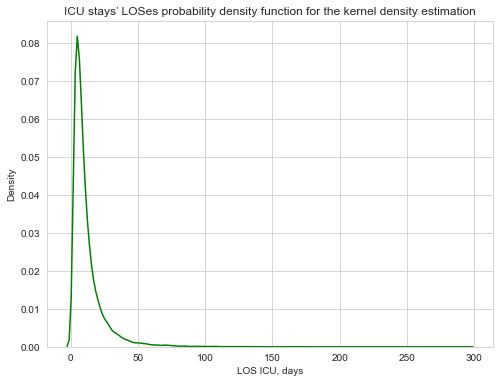

In [94]:
import seaborn as sns
df = dataset_detail.copy(deep = True)
    
sns.set_style('whitegrid')
plt.figure(figsize=(8,6))
los = sns.distplot (df['ICU_LOS_days'], bins=None, hist=False, kde=True, rug=False, fit=None, hist_kws=None, kde_kws=None, 
                        rug_kws=None, fit_kws=None, color='Green', vertical=False, norm_hist=False, axlabel='LOS ICU, days', 
                        ax=None)
plt.title('ICU stays’ LOSes probability density function for the kernel density estimation')
plt.savefig('dencity_stays_full.png', dpi = 300, bbox_inches='tight')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


(45450, 8)
(45450, 8)


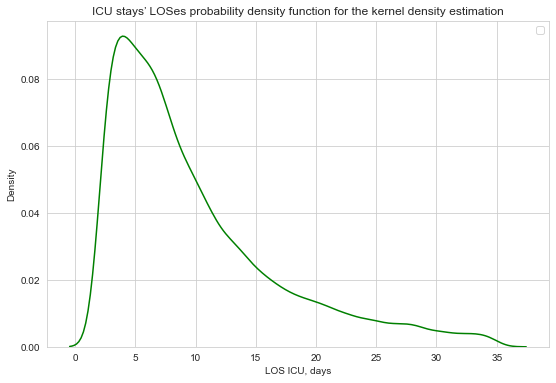

In [96]:
print(df.shape)
df = df.loc[df['ICU_LOS_days'] < 35]
print(df.shape)
sns.set_style('whitegrid')
plt.figure(figsize=(9,6))
los = sns.distplot (df['ICU_LOS_days'], bins=None, hist=False, kde=True, rug=False, fit=None, hist_kws=None, kde_kws=None, 
                        rug_kws=None, fit_kws=None, color='Green', vertical=False, norm_hist=False, axlabel='LOS ICU, days', 
                        ax=None)
plt.legend(loc='upper right')
plt.title('ICU stays’ LOSes probability density function for the kernel density estimation')
plt.savefig('dencity_stays_shortened.png', dpi = 300, bbox_inches='tight')

In [96]:
if SELECTED_FEATURE_SET or MAX_FEATURE_SET:
    # AL create a dictionary for hadm
    hadm = dataset_detail.filter(['hadm_id','icustay_id'],axis = 1)
    dict_hadm = pd.Series(hadm.hadm_id.values,index=hadm.icustay_id).to_dict()
    # fill in the missing values (to ensure correct merging of icd below)
    X.hadm_id = X.hadm_id.fillna(FILL_VALUE)
    # AL change the type to prevent warning of merging int on float
    X = X.astype({"hadm_id": int})
    a = -1
    while a < X.shape[0]-1:
        a = a+1
        if X.iat[a, X.columns.get_loc('hadm_id')] !=-1 :
            continue
        elif X.iat[a, X.columns.get_loc('hadm_id')]==-1:
            X.iat[a, X.columns.get_loc('hadm_id')] = dict_hadm[X.iat[a, X.columns.get_loc('icustay_id')]]


In [ ]:
X["ICU_LOS_days"].isnull().sum()

In [63]:
los_calculated.shape

(47752, 1)

In [58]:
# correct here
print('\n LOS description \n')
print(X['ICU_LOS_days'].describe())


#df['ICU_LOS_days'].mean()
#df['ICU_LOS_days'].quantile(0.25)
#df['ICU_LOS_days'].quantile(0.5)
#df['ICU_LOS_days'].quantile(0.75)


 LOS description 

count     11930148.00
unique        4482.00
top             30.81
freq         45785.00
Name: ICU_LOS_days, dtype: float64


In [20]:

print(dataset_detail['icustay_id'].nunique())
print(X['icustay_id'].nunique())
print(dataset_detail['subject_id'].nunique())


47752
47752
34516


# For testing purpose, use small amount of data first

In [310]:
#For testing purpose, use small amount of data first
if TESTING:
    rest, id_list = train_test_split(id_list, test_size= 0.01, random_state=42)
    X = X[X.icustay_id.isin(id_list)].sort_values(by=['icustay_id'])
    dataset_detail = dataset_detail[dataset_detail.icustay_id.isin(id_list)].sort_values(by=['icustay_id'])

# Resample  and impute

In [97]:
if (TIME_SAMPLING and MOST_COMMON):
    print("resampling: MOST_COMMON")
    # Resample the data using assigned interval,mode() for most common
    X = X.set_index('charttime').groupby('icustay_id').resample(SAMPLING_INTERVAL).mode().reset_index()  
elif TIME_SAMPLING:
    print("resampling: MEAN & ZERO")
    # Sampling with different strategies per kind of variable
    # AL adding if-else to make it work
    label = ['aki_stage']
    skip = ['icustay_id', 'charttime', 'aki_stage']
    if SELECTED_FEATURE_SET or MAX_FEATURE_SET:
        discrete_feat = ['sedative', 'vasopressor', 'vent', 'hadm_id']
        skip.extend(discrete_feat)    
    # all features that are not in skip are numeric
    numeric_feat = list(X.columns.difference(skip))
    
    # Applying aggregation to features depending on their type
    X = X.set_index('charttime').groupby('icustay_id').resample(SAMPLING_INTERVAL)
    if SELECTED_FEATURE_SET or MAX_FEATURE_SET:
        X_discrete = X[discrete_feat].max().fillna(FILL_VALUE).astype(np.int64)
    X_numeric = X[numeric_feat].mean()
    X_label = X['aki_stage'].max().ffill(limit=RESAMPLE_LIMIT)
    
    
    print("Merging sampled features")
    try:
        X = pd.concat([X_numeric, X_discrete,X_label], axis=1).reset_index()
    except:
        X = pd.concat([X_numeric,X_label], axis=1).reset_index()


resampling: MEAN & ZERO
Merging sampled features


In [206]:
# MISSING after resampling (right before imputing)

print("albumin_avg %.2f" % (X.isnull().sum()[2]/X.shape[0]*100))
print("aniongap_avg %.2f" % (X.isnull().sum()[3]/X.shape[0]*100))
print("bicarbonate_avg %.2f" % (X.isnull().sum()[4]/X.shape[0]*100))
print("bilirubin_avg %.2f" % (X.isnull().sum()[5]/X.shape[0]*100))
print("bun_avg %.2f" % (X.isnull().sum()[6]/X.shape[0]*100))
print("chloride_avg %.2f" % (X.isnull().sum()[7]/X.shape[0]*100))
print("creat %.2f" % (X.isnull().sum()[8]/X.shape[0]*100))
print("diasbp_mean %.2f" % (X.isnull().sum()[9]/X.shape[0]*100))
print("glucose_avg %.2f" % (X.isnull().sum()[10]/X.shape[0]*100))
print("heartrate_mean %.2f" % (X.isnull().sum()[11]/X.shape[0]*100))
print("hematocrit_avg %.2f" % (X.isnull().sum()[12]/X.shape[0]*100))
print("hemoglobin_avg %.2f" % (X.isnull().sum()[13]/X.shape[0]*100))
print("potassium_avg %.2f" % (X.isnull().sum()[14]/X.shape[0]*100))
print("resprate_mean %.2f" % (X.isnull().sum()[15]/X.shape[0]*100))
print("sodium_avg %.2f" % (X.isnull().sum()[16]/X.shape[0]*100))
print("spo2 %.2f" % (X.isnull().sum()[17]/X.shape[0]*100))
print("sysbp_mean %.2f" % (X.isnull().sum()[18]/X.shape[0]*100))
print("uo_rt_6hr %.2f" % (X.isnull().sum()[19]/X.shape[0]*100))
print("wbc_avg %.2f" % (X.isnull().sum()[22]/X.shape[0]*100))

print("percentage fo rows having all measures on a timestamp %.2f" % (X.dropna().shape[0]/X.shape[0]*100))
print(X.dropna().shape[0])
X.isnull().sum()

albumin_avg 95.14
aniongap_avg 71.15
bicarbonate_avg 70.69
bilirubin_avg 92.59
bun_avg 70.14
chloride_avg 69.37
creat 69.54
diasbp_mean 62.14
glucose_avg 54.11
heartrate_mean 61.82
hematocrit_avg 66.95
hemoglobin_avg 71.48
potassium_avg 64.52
resprate_mean 62.01
sodium_avg 68.43
spo2 62.22
sysbp_mean 62.14
uo_rt_6hr 67.35
wbc_avg 72.64
percentage fo rows having both measures on a timestamp 1.15
24870


icustay_id               0
charttime                0
albumin_avg        2051618
aniongap_avg       1534459
bicarbonate_avg    1524395
bilirubin_avg      1996829
bun_avg            1512502
chloride_avg       1495910
creat              1499690
diasbp_mean        1340102
glucose_avg        1166946
heartrate_mean     1333095
hematocrit_avg     1443764
hemoglobin_avg     1541518
potassium_avg      1391410
resprate_mean      1337254
sodium_avg         1475618
spo2_mean          1341789
sysbp_mean         1340057
uo_rt_12hr         1452418
uo_rt_24hr         1452418
uo_rt_6hr          1452418
wbc_avg            1566605
sedative                 0
vasopressor              0
vent                     0
hadm_id                  0
aki_stage           399321
dtype: int64

In [205]:
X.isnull().sum()[22]

1566605

In [100]:
a = X.groupby(['icustay_id'],as_index=False).size()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
No handles with labels found to put in legend.


(47751, 2)


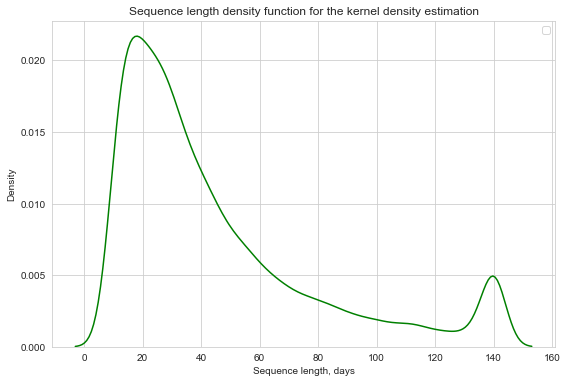

In [102]:
print(a.shape)
import seaborn as sns 
sns.set_style('whitegrid')
plt.figure(figsize=(9,6))
los = sns.distplot (a['size'], bins=None, hist=False, kde=True, rug=False, fit=None, hist_kws=None, kde_kws=None, 
                        rug_kws=None, fit_kws=None, color='Green', vertical=False, norm_hist=False, axlabel='Sequence length, days', 
                        label="", ax=None)
plt.legend(loc='upper right')

plt.title('Sequence length density function for the kernel density estimation')
plt.savefig('sequences distribution.png', dpi = 300, bbox_inches='tight')

In [312]:
print("Do imputation again if there are still missing values")
# do imputation if there are still missing values

# using most common within each icustay_id
if IMPUTE_EACH_ID:
    # set a new variable so won't change the orginial X
    column_name = list(X.columns)
    column_name.remove(column_name[0])
    
    for feature in column_name:
        X.loc[X[feature].isnull(), feature] = X.icustay_id.map(fast_mode(X, ['icustay_id'], feature).set_index('icustay_id')[feature])
        
# imputation based on whole column
if IMPUTE_COLUMN:
    imp = SimpleImputer(missing_values=np.nan, strategy= IMPUTE_METHOD)
    X=imp.fit_transform(X)
    
# If no imputation, fill missing value direclty with FILL_VALUE
if IMPUTE_COLUMN==False and IMPUTE_EACH_ID==False: #AL added this condition
    X = X.fillna(FILL_VALUE)
    

Do imputation again if there are still missing values


In [313]:
if ALL_STAGES:
    pass
elif CLASS1:
    X.loc[X['aki_stage'] > 1, 'aki_stage'] = 1
elif CLASS2:
    X.loc[X['aki_stage'] < 2, 'aki_stage'] = 0
    X.loc[X['aki_stage'] > 1, 'aki_stage'] = 1
elif CLASS3:
    X.loc[X['aki_stage'] < 3, 'aki_stage'] = 0
    X.loc[X['aki_stage'] > 2, 'aki_stage'] = 1